In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 이미지 출력

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
# 3D 데이터셋 생성

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - np.pi / 2  # -90도 ~ 180도 사이 임의의 각도
    data = np.empty((m, 3)) # 60 X 3 배열 생성
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2 # x = cos(Θ) + sin(Θ)/2 + 노이즈
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2 # y = 0.7sin(Θ) + 노이즈
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m) # z = W1x + W2y + 노이즈
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
# 오토인코더 생성

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.1))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)
codings = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 9s 17ms/step - loss: 0.9757
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6764
Epoch 3/20
2/2 [==============================] - 0s 24ms/step - loss: 0.5237
Epoch 4/20
2/2 [==============================] - 0s 23ms/step - loss: 0.4293
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3654
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3188
Epoch 7/20
2/2 [==============================] - 0s 16ms/step - loss: 0.2827
Epoch 8/20
2/2 [==============================] - 0s 8ms/step - loss: 0.2542
Epoch 9/20
2/2 [==============================] - 0s 12ms/step - loss: 0.2302
Epoch 10/20
2/2 [==============================] - 0s 13ms/step - loss: 0.2107
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.1928
Epoch 12/20
2/2 [==============================] - 0s 13ms/step - loss: 0.1777
Epoch 13/20
2/2 [==============================] - 0s 9ms/step -

오토인코더 출력 값이 원본 데이터와 거의 유사하게 값이 나오기 위해서 인코딩 층에서 원본 데이터를 가장 잘 표현하는 방향으로 저차원으로 투영되야한다.

따라서 인코딩 층을 지나면 PCA와 유사하게 데이터의 분산이 가장 잘 보존되도록 데이터를 투영할 최상의 2차원 평면을 찾는다.

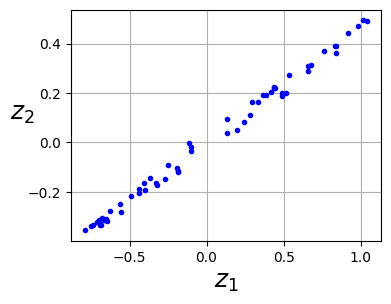

In [6]:
# 3차원 데이터를 2차원으로 투영

fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [7]:
# 패션 MNIST데이터 불러오기

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

오토인코더에 은닉층을 여러 개 추가하여 적층 오토인코더를 만들 수 있다.

아래는 28X28사이즈의 패션 MNIST데이터를 인코더에서 순서대로 100개의 뉴런, 30개의 뉴런으로 축소시키고, 디코더에서 100개의 뉴런, 28X28개의 뉴런으로 복원하는 작업이다.

학습을 하기 위해 인코더는 Flatten을 사용해 1차원으로 변경시켜주고 디코더에서 Reshape으로 픽셀 이미지로 다시 돌려준다.

컴파일 할 때는 이진 크로스 엔트로피 손실을 사용했는데 이는 각 픽셀이 검정일 확률을 나타낸다.

In [9]:
# 적층 오토인코더 - 3개의 은닉층 & 1개 출력층 모델

#인코더
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

#디코더
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 15s 4ms/step - loss: 0.3385 - rounded_accuracy: 0.8865 - val_loss: 0.3202 - val_rounded_accuracy: 0.8947
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3060 - rounded_accuracy: 0.9147 - val_loss: 0.3031 - val_rounded_accuracy: 0.9191
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2999 - rounded_accuracy: 0.9201 - val_loss: 0.2987 - val_rounded_accuracy: 0.9225
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2962 - rounded_accuracy: 0.9233 - val_loss: 0.2982 - val_rounded_accuracy: 0.9237
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2934 - rounded_accuracy: 0.9257 - val_loss: 0.2953 - val_rounded_accuracy: 0.9222
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2916 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9276
Epoch 7/20
1719/1719 [=================

1/1 [==============================] - 0s 67ms/step


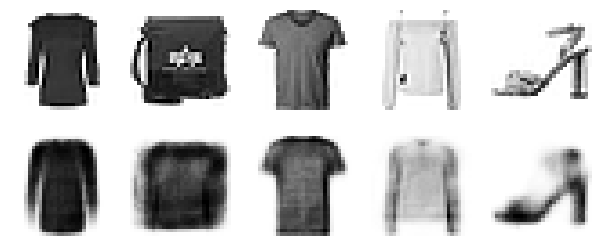

In [10]:
# 원본 이미지와 재구성 이미지 비교

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):

        # 원본 이미지
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])

        # 생성된 이미지
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)

157/157 [==============================] - 0s 1ms/step


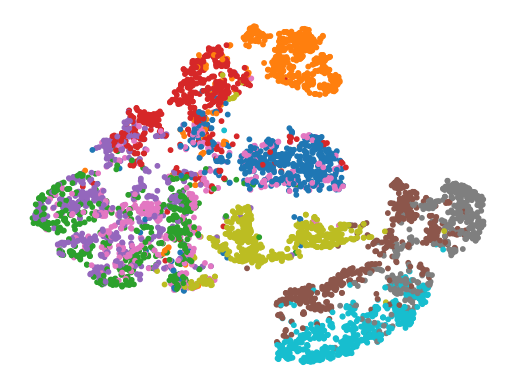

In [11]:
# 패션 MNIST 시각화

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min()) # 값 범위를 0 ~ 1로

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

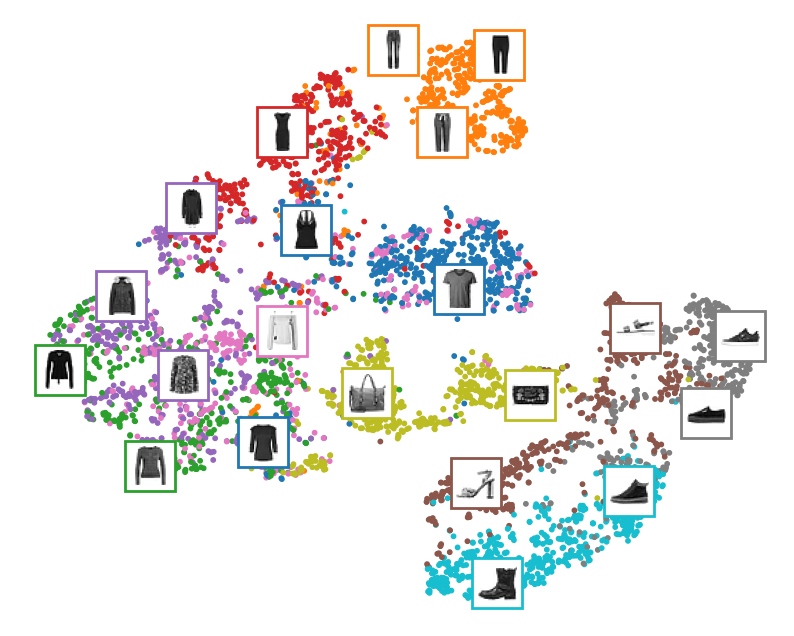

In [12]:
# 산점도에 대표 이미지 표시

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)

    # 충분히 멀리 떨어져 있는 이미지
    if np.min(dist) > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")

plt.show()

In [13]:
# 가중치 묶기 - 오토인코더가 대칭인 경우

class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [14]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3276 - rounded_accuracy: 0.8953 - val_loss: 0.3128 - val_rounded_accuracy: 0.9143
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2980 - rounded_accuracy: 0.9220 - val_loss: 0.2939 - val_rounded_accuracy: 0.9270
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2915 - rounded_accuracy: 0.9282 - val_loss: 0.2905 - val_rounded_accuracy: 0.9321
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2883 - rounded_accuracy: 0.9312 - val_loss: 0.2896 - val_rounded_accuracy: 0.9280
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2863 - rounded_accuracy: 0.9330 - val_loss: 0.2871 - val_rounded_accuracy: 0.9316
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2850 - rounded_accuracy: 0.9342 - val_loss: 0.2852 - val_rounded_accuracy: 0.9341
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 64ms/step


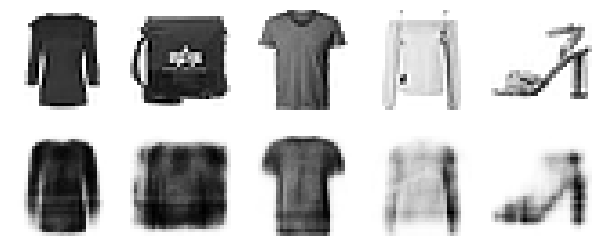

In [15]:
show_reconstructions(tied_ae)
plt.show()

In [16]:
# 한 번에 하나의 오토인코더 훈련

def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [17]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train)
X_valid_flat = K.batch_flatten(X_valid)

# 첫 번째 오토인코더
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])

# 두 번째 오토인코더
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3448 - rounded_accuracy: 0.8871 - val_loss: 0.3130 - val_rounded_accuracy: 0.9134
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3047 - rounded_accuracy: 0.9196 - val_loss: 0.3014 - val_rounded_accuracy: 0.9243
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2957 - rounded_accuracy: 0.9279 - val_loss: 0.2942 - val_rounded_accuracy: 0.9305
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2900 - rounded_accuracy: 0.9334 - val_loss: 0.2896 - val_rounded_accuracy: 0.9351
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2863 - rounded_accuracy: 0.9369 - val_loss: 0.2866 - val_rounded_accuracy: 0.9379
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2836 - rounded_accuracy: 0.9395 - val_loss: 0.2843 - val_rounded_accuracy: 0.9403
Epoch 7/10
1719/1719 [==================

In [18]:
# 두 오토인코더 적층하기

stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2856 - rounded_accuracy: 0.9357 - val_loss: 0.2872 - val_rounded_accuracy: 0.9354
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2853 - rounded_accuracy: 0.9361 - val_loss: 0.2870 - val_rounded_accuracy: 0.9355
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2851 - rounded_accuracy: 0.9363 - val_loss: 0.2869 - val_rounded_accuracy: 0.9359
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2850 - rounded_accuracy: 0.9364 - val_loss: 0.2867 - val_rounded_accuracy: 0.9361
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2849 - rounded_accuracy: 0.9366 - val_loss: 0.2867 - val_rounded_accuracy: 0.9359
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2847 - rounded_accuracy: 0.9366 - val_loss: 0.2865 - val_rounded_accuracy: 0.9363
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 66ms/step


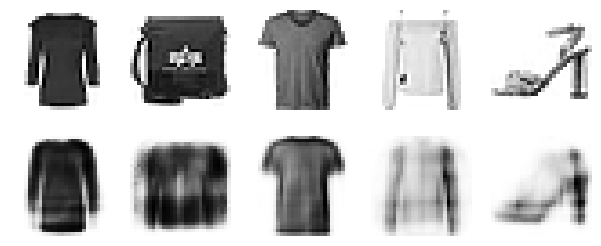

In [19]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [20]:
# 합성곱 오토인코더

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 16s 6ms/step - loss: 0.3003 - rounded_accuracy: 0.9200 - val_loss: 0.2804 - val_rounded_accuracy: 0.9373
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2757 - rounded_accuracy: 0.9417 - val_loss: 0.2757 - val_rounded_accuracy: 0.9408
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2711 - rounded_accuracy: 0.9464 - val_loss: 0.2698 - val_rounded_accuracy: 0.9495
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2684 - rounded_accuracy: 0.9492 - val_loss: 0.2680 - val_rounded_accuracy: 0.9515
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2666 - rounded_accuracy: 0.9511 - val_loss: 0.2678 - val_rounded_accuracy: 0.9516


In [21]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

합성곱 오토인코더에서 인코더는 공간 방향의 차원을 줄이고 싶이를 늘리는 것을 볼 수 있다.

디코더는 반대로 원본으로 복원해야하기 때문에 전치 합성곱 층을 사용해서 이미지의 스케일을 늘리고 깊이를 원본 차원으로 되돌리는 것을 볼 수 있다.

1/1 [==============================] - 0s 356ms/step


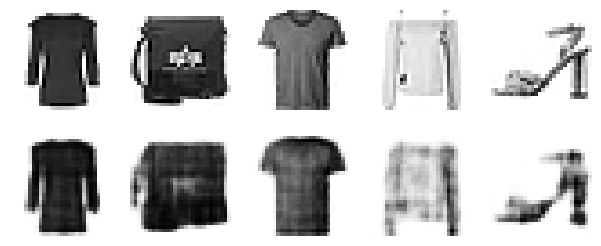

In [22]:
show_reconstructions(conv_ae)
plt.show()

In [23]:
# 순환 오토인코더

recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 24s 11ms/step - loss: 0.5148 - rounded_accuracy: 0.7486 - val_loss: 0.4467 - val_rounded_accuracy: 0.8156
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4000 - rounded_accuracy: 0.8455 - val_loss: 0.3739 - val_rounded_accuracy: 0.8672
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3648 - rounded_accuracy: 0.8714 - val_loss: 0.3612 - val_rounded_accuracy: 0.8760
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3513 - rounded_accuracy: 0.8814 - val_loss: 0.3497 - val_rounded_accuracy: 0.8841
Epoch 5/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.3419 - rounded_accuracy: 0.8875 - val_loss: 0.3377 - val_rounded_accuracy: 0.8929
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3346 - rounded_accuracy: 0.8920 - val_loss: 0.3320 - val_rounded_accuracy: 0.8952
Epoch 7/10
1719/1719 [======

1/1 [==============================] - 1s 1s/step


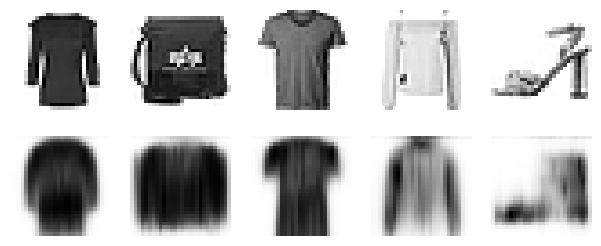

In [24]:
show_reconstructions(recurrent_ae)
plt.show()

In [25]:
# 적층 잡음 제거 오토인코더 - 가우시안 잡음

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2), # 가우시안 노이즈 추가
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3494 - rounded_accuracy: 0.8779 - val_loss: 0.3183 - val_rounded_accuracy: 0.9051
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3129 - rounded_accuracy: 0.9093 - val_loss: 0.3081 - val_rounded_accuracy: 0.9154
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3055 - rounded_accuracy: 0.9156 - val_loss: 0.3025 - val_rounded_accuracy: 0.9206
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3017 - rounded_accuracy: 0.9187 - val_loss: 0.2993 - val_rounded_accuracy: 0.9225
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2990 - rounded_accuracy: 0.9211 - val_loss: 0.2967 - val_rounded_accuracy: 0.9253
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2968 - rounded_accuracy: 0.9230 - val_loss: 0.2947 - val_rounded_accuracy: 0.9274
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 67ms/step


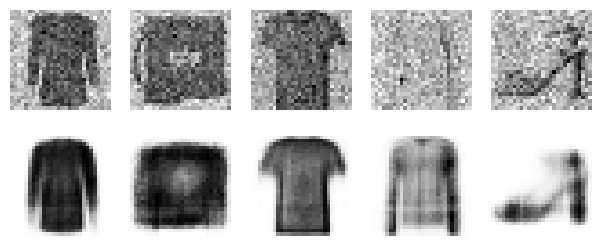

In [26]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

가우시안 노이즈가 추가된 위의 이미지를 입력 받고 아래와 같이 노이즈를 잘 해결하여 적절한 이미지를 생성하였다.

In [27]:
# 적층 잡음 제거 오토인코더 - 드롭아웃

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5), # 드롭아웃 추가
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3569 - rounded_accuracy: 0.8705 - val_loss: 0.3206 - val_rounded_accuracy: 0.9050
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3190 - rounded_accuracy: 0.9022 - val_loss: 0.3126 - val_rounded_accuracy: 0.9108
Epoch 3/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3132 - rounded_accuracy: 0.9072 - val_loss: 0.3078 - val_rounded_accuracy: 0.9143
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3093 - rounded_accuracy: 0.9104 - val_loss: 0.3045 - val_rounded_accuracy: 0.9174
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3064 - rounded_accuracy: 0.9125 - val_loss: 0.3021 - val_rounded_accuracy: 0.9195
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3045 - rounded_accuracy: 0.9141 - val_loss: 0.3000 - val_rounded_accuracy: 0.9201
Epoch 7/10
1719/1719 [================

1/1 [==============================] - 0s 68ms/step


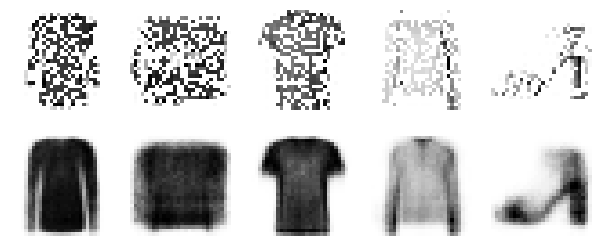

In [28]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

드롭아웃이 적용된 위의 이미지를 받아서 아래와 같이 적절한 이미지를 생성하였다.

In [29]:
# 적층 오토인코더

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4292 - rounded_accuracy: 0.7996 - val_loss: 0.3764 - val_rounded_accuracy: 0.8511
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3594 - rounded_accuracy: 0.8703 - val_loss: 0.3499 - val_rounded_accuracy: 0.8792
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3419 - rounded_accuracy: 0.8838 - val_loss: 0.3393 - val_rounded_accuracy: 0.8855
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3310 - rounded_accuracy: 0.8934 - val_loss: 0.3284 - val_rounded_accuracy: 0.8924
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3216 - rounded_accuracy: 0.9014 - val_loss: 0.3206 - val_rounded_accuracy: 0.9017
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3172 - rounded_accuracy: 0.9046 - val_loss: 0.3175 - val_rounded_accuracy: 0.9081
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 65ms/step


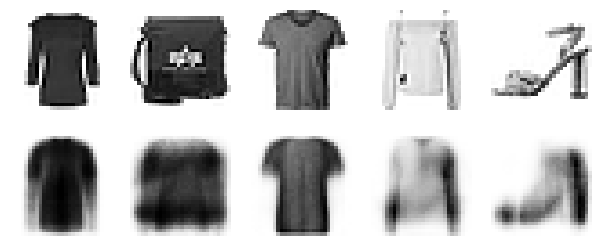

In [30]:
show_reconstructions(simple_ae)
plt.show()

In [31]:
# 활성화 히스토그램 출력 함수

def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

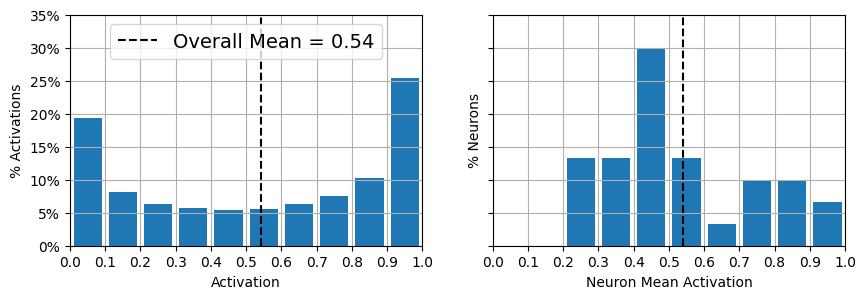

In [33]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

적층 오토인코더를 사용한 결과를 활성화 히스토그램 출력 함수를 사용해 인코딩 층의 활성화에 대한 히스토그램을 출력해 보면 왼쪽의 경우 전체 활성화 분포를 보여준다.

그래프를 보면 0와 1에 가까운 값이 많이 나오는것을 볼 수 있는데 이는 활성화 함수로 시그모이드를 사용하기 때문이다.

 오른쪽의 히스토그램은 평균 뉴런의 분포를 보여주는데 대부분의 뉴런이 0.5에 가까운 평균 활성화를 가지고 있다.

 이는 각 뉴런이 50% 확률로 0이나 1에 가까운 값에 활성화된다는 것을 보여준다.

 이제 좋은 특성을 추출하기 위해서 희소 오토인코더를 사용해보면 먼저 코딩층의 크기를 확장해야한다.

 코딩층을 더 크게 만드는 이유는 크기가 커지면 더 많은 유닛을 사용할 수 있어 희소성이 커지기 때문이다.

 따라서 희소 오토인코더에서는 입력 데이터의 특징을 높은 차원의 표현으로 인코딩하고, 이를 활용하여 더 희소하고 의미 있는 데이터 표현을 얻는다.

In [ ]:
# 희소 오토인코더

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)
    ])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
    ])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4330 - rounded_accuracy: 0.8107 - val_loss: 0.3859 - val_rounded_accuracy: 0.8470
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3701 - rounded_accuracy: 0.8681 - val_loss: 0.3648 - val_rounded_accuracy: 0.8737
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3562 - rounded_accuracy: 0.8781 - val_loss: 0.3516 - val_rounded_accuracy: 0.8833
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3449 - rounded_accuracy: 0.8863 - val_loss: 0.3434 - val_rounded_accuracy: 0.8891
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3384 - rounded_accuracy: 0.8905 - val_loss: 0.3378 - val_rounded_accuracy: 0.8933
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3332 - rounded_accuracy: 0.8948 - val_loss: 0.3323 - val_rounded_accuracy: 0.8972
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 125ms/step


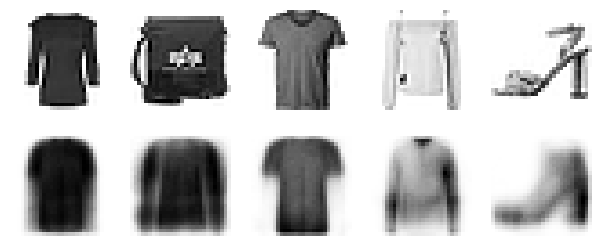

In [ ]:
show_reconstructions(sparse_l1_ae)
plt.show()

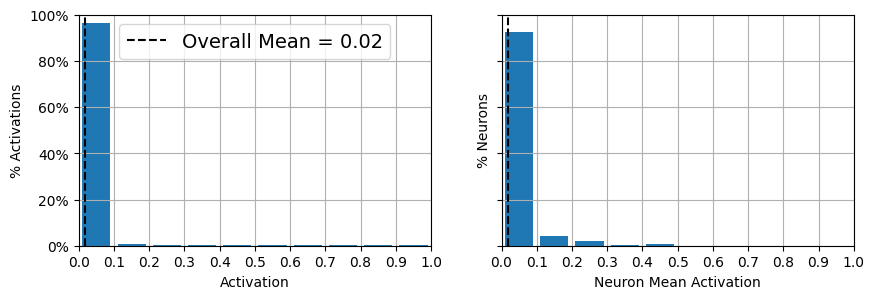

In [ ]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

이를 통해서 대부분이 활성되지 않고 0의 값만 많이 나오는것을 볼 수 있다.

KL 발산

$
D_{\mathrm{KL}}(p\|q) = p \, \log \dfrac{p}{q} + (1-p) \log \dfrac{1-p}{1-q}
$

(0.0, 1.0, 0.0, 0.95)

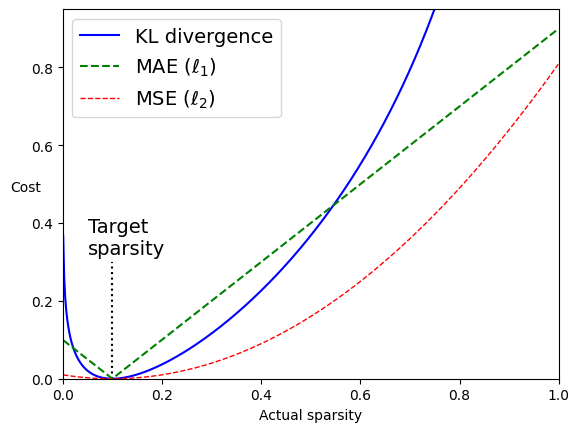

In [34]:
# KL 발산을 사용하여 10%의 희소성 생성

p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [35]:
# KL 사용자 정의 규제

K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1): # 10%의 희소성 활성화
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [36]:
# KLDivergenceRegularizer을 적용한 희소 오토인코더

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 8ms/step - loss: 0.4146 - rounded_accuracy: 0.8141 - val_loss: 0.3691 - val_rounded_accuracy: 0.8610
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3515 - rounded_accuracy: 0.8784 - val_loss: 0.3426 - val_rounded_accuracy: 0.8869
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3334 - rounded_accuracy: 0.8923 - val_loss: 0.3294 - val_rounded_accuracy: 0.8973
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3219 - rounded_accuracy: 0.9025 - val_loss: 0.3208 - val_rounded_accuracy: 0.9037
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3164 - rounded_accuracy: 0.9069 - val_loss: 0.3165 - val_rounded_accuracy: 0.9080
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3130 - rounded_accuracy: 0.9097 - val_loss: 0.3136 - val_rounded_accuracy: 0.9112
Epoch 7/10
1719/1719 [=============

1/1 [==============================] - 1s 513ms/step


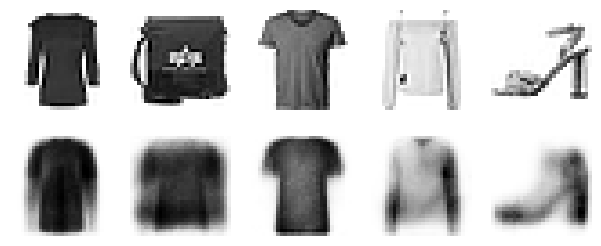

In [37]:
show_reconstructions(sparse_kl_ae)
plt.show()

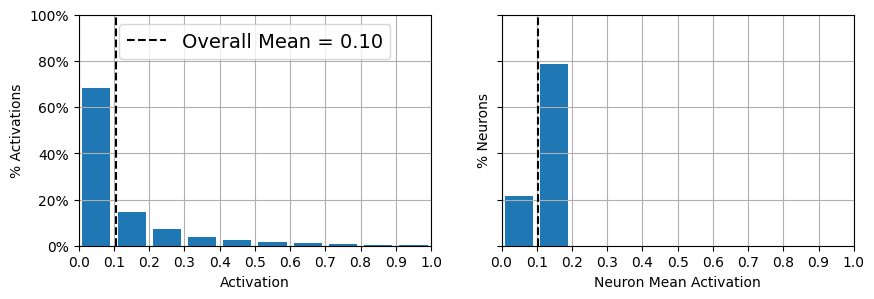

In [38]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

우리가 원하는 결과와 같이 10%가 활성화 된 것을 볼 수 있다.

In [39]:
# 평균과 표준편차로 코딩 샘플링

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean


잠재 손실과 재구성 손실은 오토인코더 모델의 두 가지 중요한 손실 함수의 구성요소이다.

잠재 손실은 인코더 부분이 생성하는 잠재 공간의 표현에 대한 손실을 나타내는 것으로 잠재 공간의 표현이 특정 속성을 가지도록 유도하거나 제약하는 데 사용된다.

재구성 손실은 오토인코더에서 입력 데이터를 다시 재구성한 출력과 원본 입력 데이터 간의 차이를 나타내는 것으로 오토인코더가 복원하는 데 얼마나 효과적인지를 판단한다.

변이형 오토인코더의 잠재 손실

$\mathcal{L} = - \dfrac{1}{2} \sum\limits_{i=1}^n 1 + \gamma_i - \exp(\gamma_i) - \mu_i^2$

In [40]:
# 변이형 오토인코더

codings_size = 10

# 인코더 - 함수형 API
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

# 디코더 - 시퀀셜 API
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# 잠재 손실
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

# 재구성 손실
variational_ae.add_loss(K.mean(latent_loss) / 784.)

variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 6s 9ms/step - loss: 0.4139 - rounded_accuracy: 0.8356 - val_loss: 0.3648 - val_rounded_accuracy: 0.8781
Epoch 2/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3546 - rounded_accuracy: 0.8890 - val_loss: 0.3547 - val_rounded_accuracy: 0.8880
Epoch 3/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3437 - rounded_accuracy: 0.8969 - val_loss: 0.3408 - val_rounded_accuracy: 0.9011
Epoch 4/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3372 - rounded_accuracy: 0.9023 - val_loss: 0.3375 - val_rounded_accuracy: 0.9058
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3327 - rounded_accuracy: 0.9058 - val_loss: 0.3349 - val_rounded_accuracy: 0.9056
Epoch 6/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3297 - rounded_accuracy: 0.9079 - val_loss: 0.3324 - val_rounded_accuracy: 0.9078
Epoch 7/25
430/430 [==============================] 

1/1 [==============================] - 0s 185ms/step


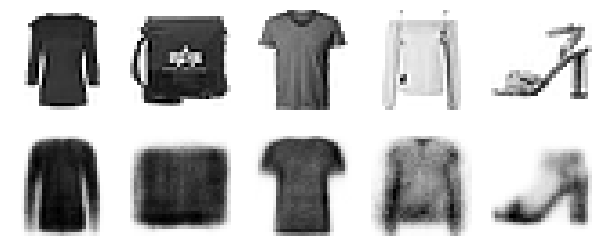

In [41]:
show_reconstructions(variational_ae)
plt.show()

In [42]:
# 여러 이미지 출력

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

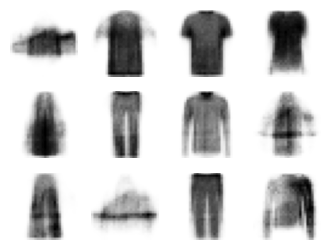

In [43]:
# 변이형 오토인코더로 패션 MNIST 이미지 생성

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

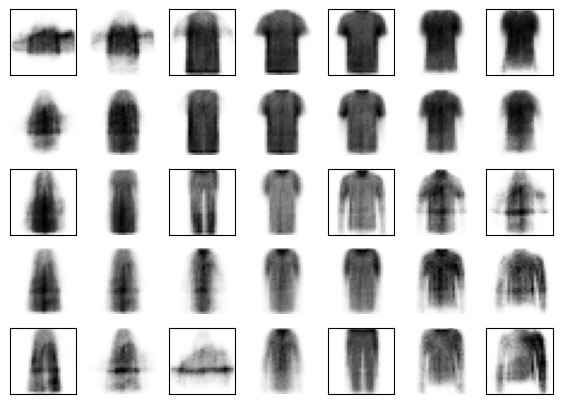

In [44]:
# 시맨틱 보간

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7]) # 이중 선형 보간
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

보간을 했을 때 완전히 다른 부위에 입는 옷들은 이상하게 되었지만 같은 상의의 경우 상당히 좋은 이미지를 생성해 낸 것을 볼 수 있다.

In [45]:
# GAN

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [46]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop") # 이진 분류기이기 때문에 크로스 엔트로피 사용
discriminator.trainable = False # 판별자가 훈련되지 않게 설정
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [47]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

판별자 훈련 과정에서 가우시안 잡음을 생성자에 주입하여 가짜 이미지 생성하고 이와 동일한 개수의 진짜 이미지를 합쳐서 배치를 완성한다.

그리고 생성자 훈련을 할 때 노이즈를 넣어 생성자가 먼저 가짜 이미지를 생성하고 판별자가 이 이미지가 진짜인지 가짜인지 추측한다.

In [52]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=5):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:

            # 판별자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # 생성자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

Epoch 1/10


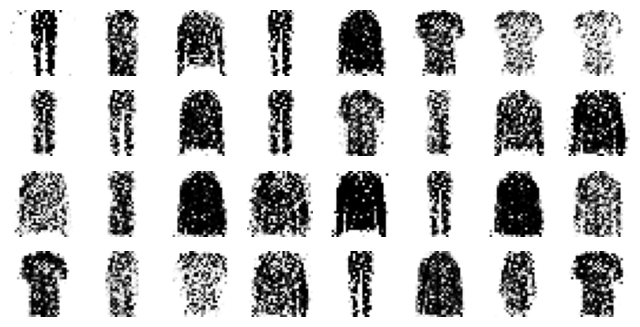

Epoch 2/10


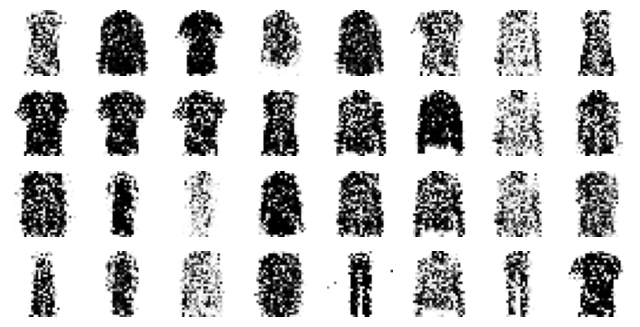

Epoch 3/10


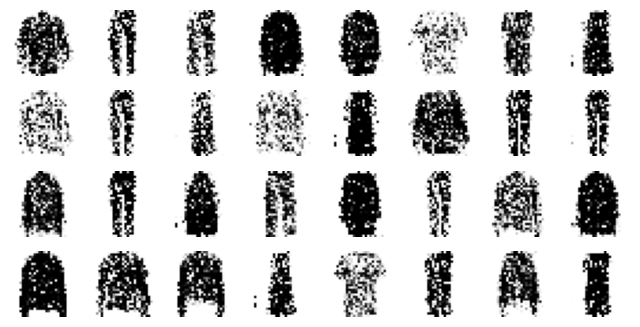

Epoch 4/10


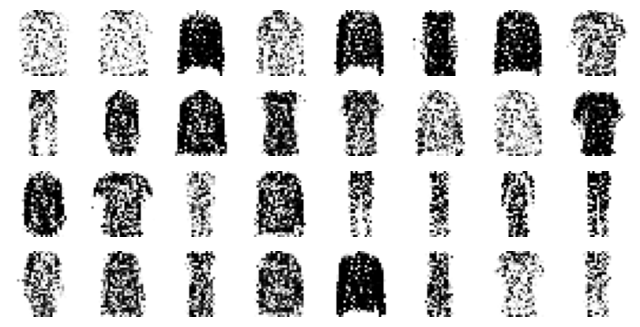

Epoch 5/10


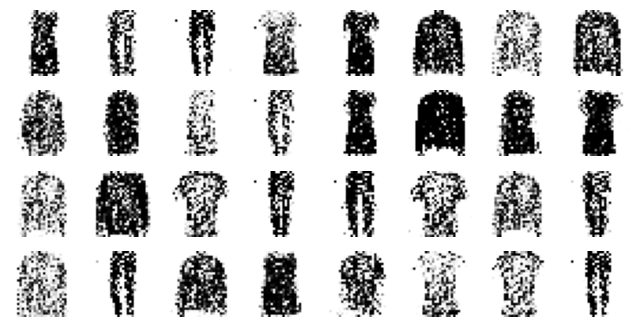

Epoch 6/10


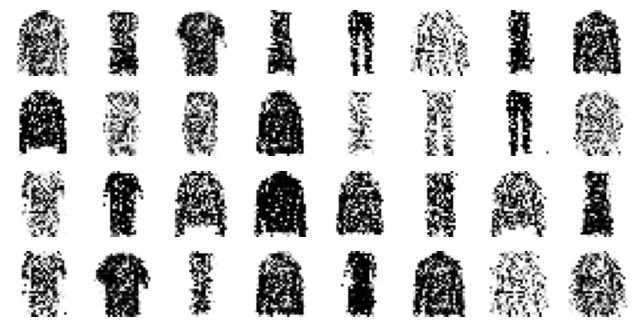

Epoch 7/10


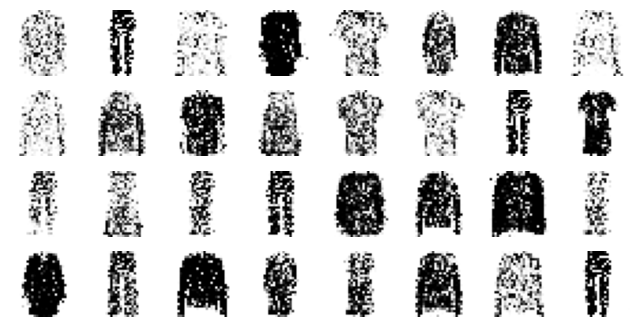

Epoch 8/10


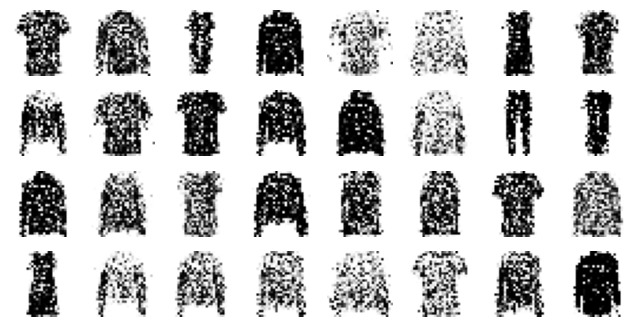

Epoch 9/10


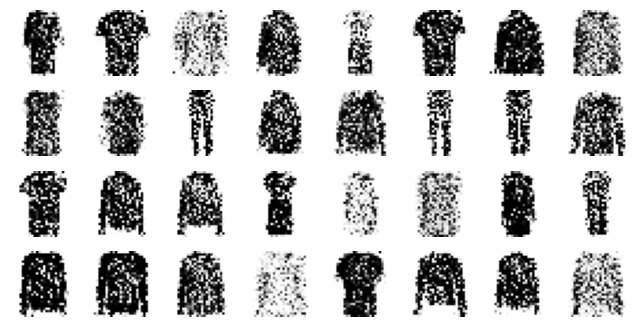

Epoch 10/10


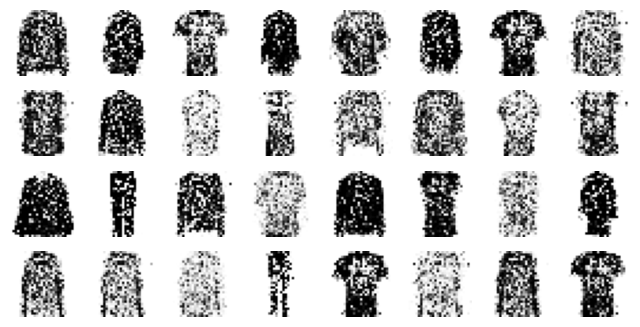

In [51]:
# GAN으로 생성된 이미지

train_gan(gan, dataset, batch_size, codings_size)

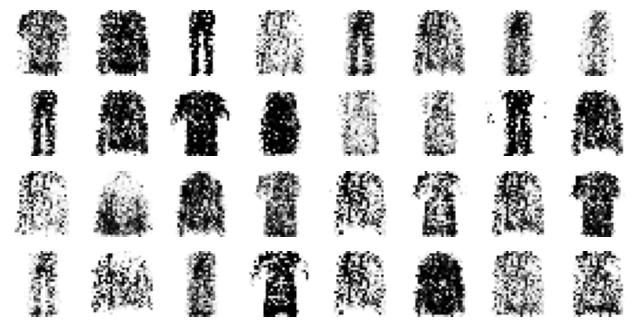

In [50]:
# 노이즈를 넣은 이미지 학습 결과

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

GAN으로 학습한 결과 원본 이미지와는 확실히 구분되는 이미지를 생성하였다.

오히려 원본 이미지에 노이즈를 추가한 형태가 결과로 나와 잘 학습이 안된것을 볼 수 있다.

따라서 심층 합성곱 GAN을 사용하여 더 좋은 결과를 봐야한다.

### 심층 합성곱 GAN(DCGAN)

먼저 판별자에 있는 풀링층을 스트라이드 합성곱으로 바꾸고, 생성자에 있는 풀링층은 전치 합성곱으로 바꾼다

생성자의 출력층과 판별자의 입력층은 제외하고 생성자와 판별자에 배치 정규화를 사용한다.

층을 깊게 쌓기 위해 완전 연결 은닉층을 제거하고 출력층에는 tanh 함수를 사용 하고 출력층을 제외한 생성자의 다른 층에는 ReLU 계열의 활성화 함수를 사용한다.

그리고 판별자는 모든 층에서 LeakyReLU를 사용한다.

In [53]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [54]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [55]:
# tanh 활성화 함수 사용하기위해 출력 범위 -1 ~ 1로 변환

X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [56]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/5


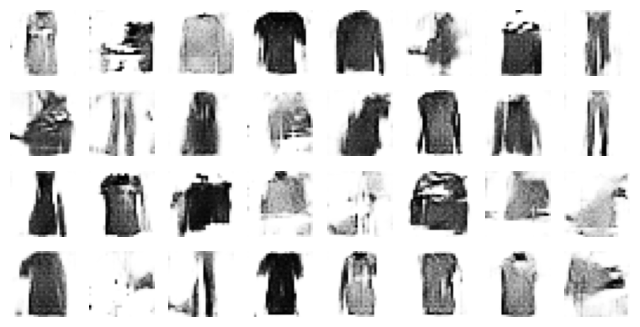

Epoch 2/5


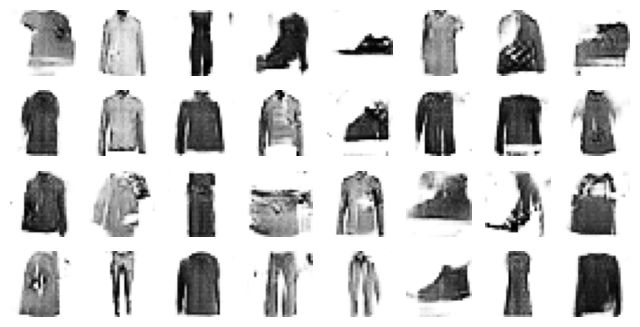

Epoch 3/5


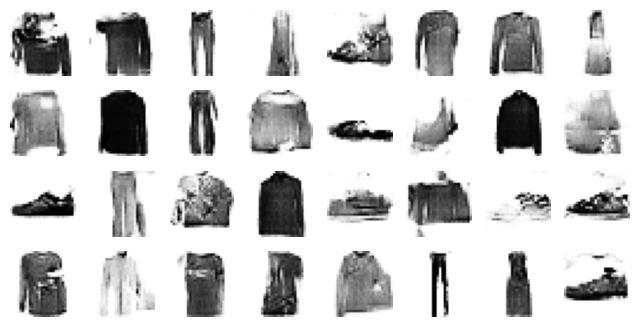

Epoch 4/5


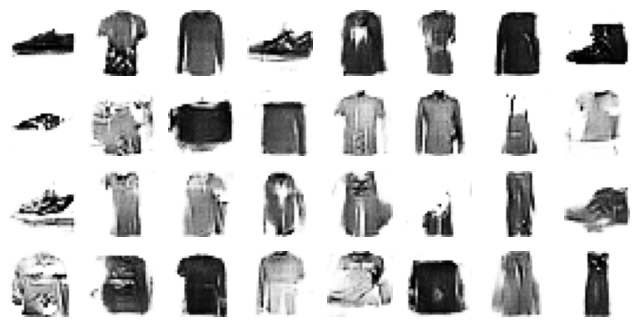

Epoch 5/5


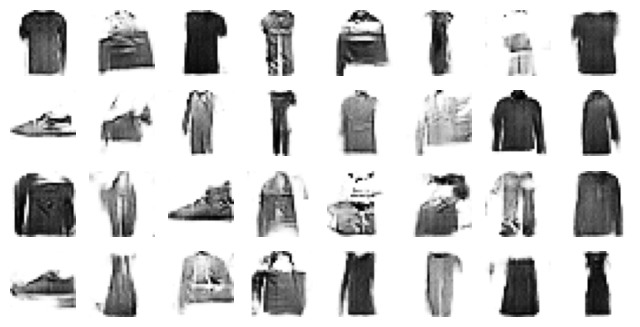

In [57]:
train_gan(gan, dataset, batch_size, codings_size)

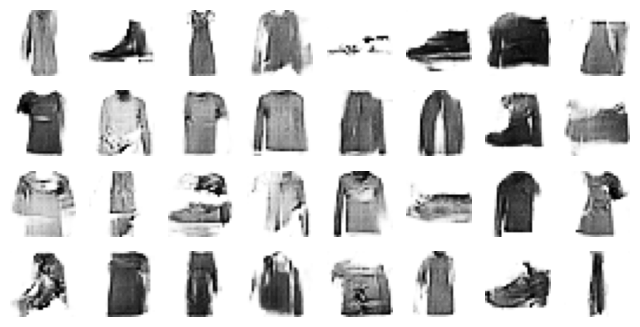

In [58]:
# 노이즈 넣은 이미지 학습 결과

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

일반적인 GAN을 사용했을 때와 비교하여 월등히 좋은 성능을 확인 할 수 있었다.